# Pooled Texture Model

This notebook will be fleshed out over the development of this PR. For now, this assumes you are familiar with the pooled texture model described in Freeman and Simoncelli, 2011 [^1], among other places, and just aims to show how to use the model, so we can get feedback

[^1]: Freeman, J., & Simoncelli, E. P. (2011). Metamers of the ventral stream. Nature Neuroscience, 14(9), 1195–1201. http://dx.doi.org/10.1038/nn.2889. [reprint](https://www.cns.nyu.edu/pub/eero/freeman10-reprint.pdf)

In [1]:
import plenoptic as po
import torch
import numpy as np
import matplotlib.pyplot as plt
import einops
# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams['figure.dpi'] = 72

# set seed for reproducibility
po.tools.set_seed(1)

# use GPU if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline


# Animation-related settings
plt.rcParams['animation.html'] = 'html5'
# use single-threaded ffmpeg for animation writer
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_args'] = ['-threads', '1']

/mnt/home/wbroderick/miniconda3/envs/plenoptic/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, grab an image. We have several built-in to plenoptic, which can all be found under `po.data`, or you can use `po.load_images` to load your own image in. Images in plenoptic need to be 4d tensors of shape `(batch, channel, height, width)`, where `batch` typically contains multiple images and channel can contain `RGB`, for example. For now, the pooled texture model treats each channel independently and so does not handle color images well. We should thus use a grayscale image, which has a single color channel.

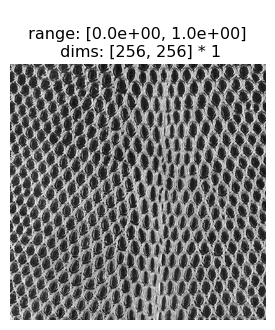

In [2]:
img = po.data.reptile_skin()
po.imshow(img);

The pooled texture model requires a mask as its input. This mask is a list of 3d non-negative tensors, of shape `(masks, height, width)`, where height and width must all match that of the target image (the model downsamples the mask to handle different scales). We will take the product of all masks in the list in order to construct the final mask. This way, users can specify e.g., two tensors each with shape `(4, height, width)` instead of a single tensor with shape `(16, height, width)`, which will be more memory efficient:

In [3]:
masks = []
for i in range(2):
    mask = [torch.zeros_like(img)[0] for i in range(4)]
    mask_sz = int(256 // len(mask))
    for j, m in enumerate(mask):
        if i == 0:
            m[..., j*mask_sz:(j+1)*mask_sz, :] = 1
        else:
            m[..., j*mask_sz:(j+1)*mask_sz] = 1
    masks.append(torch.cat(mask, 0))
print([m.shape for m in masks])

[torch.Size([4, 256, 256]), torch.Size([4, 256, 256])]


We can visualize the output of the mask as follows:

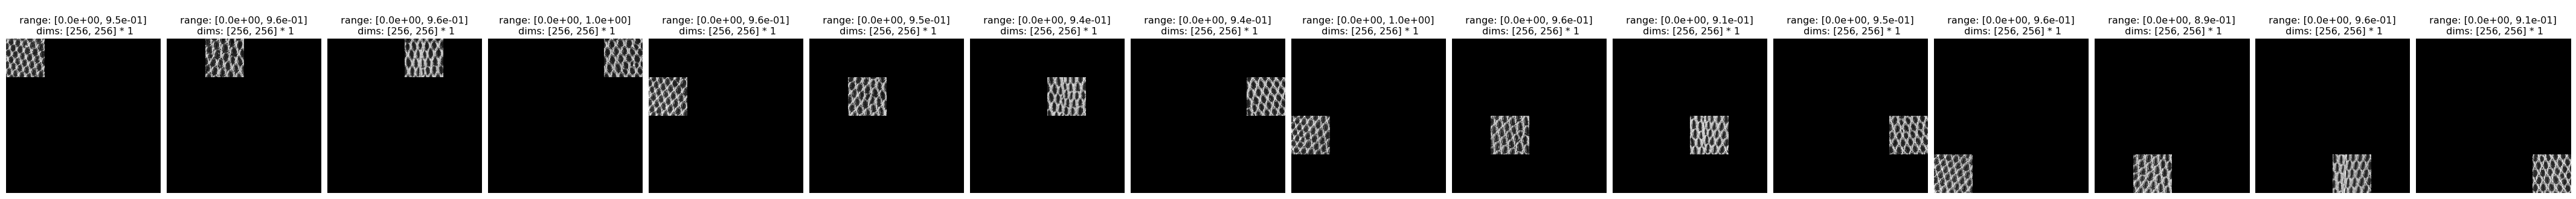

In [4]:
masked = einops.einsum(*masks, img, 'm0 h w, m1 h w, b c h w -> b c m0 m1 h w')
po.imshow(einops.rearrange(masked, 'b c m0 m1 h w -> b (c m0 m1) h w'));

This is equivalent to, but more memory-efficient than, the following: 

In [5]:
mask = [torch.zeros_like(img)[0] for i in range(16)]
mask_sz = int(256 // np.sqrt(len(mask)))
for i, m in enumerate(mask):
    x = int(i // np.sqrt(len(mask)))
    y = int(i % np.sqrt(len(mask)))
    m[..., x*mask_sz:(x+1)*mask_sz, y*mask_sz:(y+1)*mask_sz] = 1
single_masks = torch.cat(mask, 0)
single_masks.shape

torch.Size([16, 256, 256])

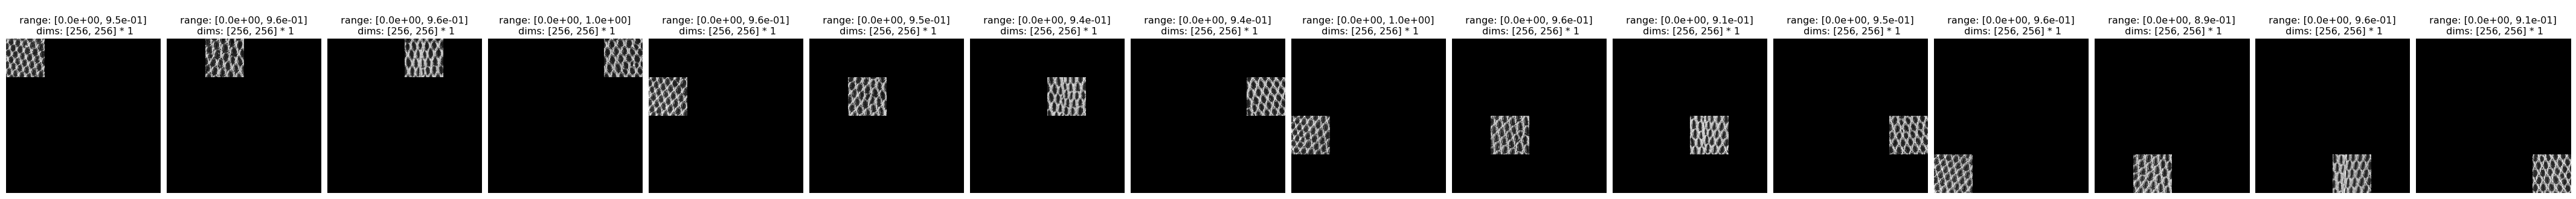

In [6]:
masked = einops.einsum(single_masks, img, 'm0 h w, b c h w -> b c m0 h w')
po.imshow(einops.rearrange(masked, 'b c m0 h w -> b (c m0) h w'));

Currently, both of these approaches are supported -- should they be? Or should we require the user to pass two masks that we multiply together? I can't think there's any case in which someone would pass a list with three or more mask tensors, but that would work as well. Even if we allow a list of masks, should we allow more than two?

Before moving on, another question: how to handle mask normalization? The model works best if the individual masks (as shown above) sum to approximately 1 because, otherwise, some of the statistics end up being much larger than the others and optimization is hard. Currently, we're **not** normalizing within the model code, but should we? What you want is to have every element of the following end up being roughly equal to 1:

In [7]:
einops.einsum(*masks, 'm0 h w, m1 h w -> m0 m1')

tensor([[4096., 4096., 4096., 4096.],
        [4096., 4096., 4096., 4096.],
        [4096., 4096., 4096., 4096.],
        [4096., 4096., 4096., 4096.]])

In this case, that means dividing each mask by `sqrt(4096)=64`:

In [8]:
masks = [m/64 for m in masks]
einops.einsum(*masks, 'm0 h w, m1 h w -> m0 m1')

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

We do ensure that the sum is constant across scales, when we downsample the masks.

Now that we have our (properly-normalized) masks, we can create out model. It requires the height and width of the image, as well as the list `masks`:

In [9]:
ps_mask = po.simul.PortillaSimoncelliMasked(img.shape[-2:], masks)

To generate the pooled texture statistics, simply pass this object an image:

In [10]:
print(ps_mask(img))
ps_mask(img).shape

tensor([[[[ 0.3839,  0.1996,  0.1234,  ...,  0.1502,  0.1148,  0.0054],
          [ 0.3770,  0.1995,  0.1248,  ...,  0.2068, -0.0482,  0.0051],
          [ 0.4332,  0.2480,  0.1611,  ...,  0.1555, -0.0754,  0.0043],
          ...,
          [ 0.4184,  0.2210,  0.1317,  ...,  0.1884,  0.0434,  0.0047],
          [ 0.4623,  0.2640,  0.1671,  ...,  0.2387,  0.0923,  0.0036],
          [ 0.4157,  0.2270,  0.1423,  ...,  0.2781,  0.0705,  0.0047]]]])


torch.Size([1, 1, 16, 1044])

The shape of the models output is `(batch, channel, masks, stats)`, where `batch, channel` match that of our input image, `masks` is the total number of masks (16 here, generally, the product of the first dimension for each element in the list `masks`), and `stats` is the number of statistics, which depends on the other parameters of the texture model (`n_orientations`, `n_scales`, and `spatial_corr_width`).

If we compare this to the regular texture model:

In [11]:
ps = po.simul.PortillaSimoncelli(img.shape[-2:])
ps(img).shape

torch.Size([1, 1, 1046])

This model takes the same initialization arguments, except for `masks`, and returns a tensor of shape `(batch, channel, stats)`, each dimension as above. The regular texture model has two more stats than the pooled ones: the max and min pixel value, which don't make sense to compute (and don't appear to be necessary) for the pooled version of the model.

Once initialized, the model can be called on any image of the appropriate size:

In [12]:
ps_mask(po.data.einstein()).shape

torch.Size([1, 1, 16, 1044])

If available, moving everything over to a GPU will speed things up greatly:

In [13]:
img = img.to(DEVICE)
ps_mask = ps_mask.to(DEVICE)

To create model metamers, make use of plenoptic's metamer object, which takes the model and target image at intialization (plenoptic has a separate object for coarse-to-fine metamer optimization):

In [14]:
met = po.synth.MetamerCTF(img, ps_mask, loss_function=po.tools.optim.l2_norm,)

/mnt/home/wbroderick/plenoptic/src/plenoptic/tools/validate.py:178: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(
/mnt/home/wbroderick/plenoptic/src/plenoptic/tools/validate.py:211: UserWarning: Validating whether model can work with coarse-to-fine synthesis -- this can take a while!
  warnings.warn("Validating whether model can work with coarse-to-fine synthesis -- this can take a while!")


Then call the `synthesize()` method, which requires some additional arguments describing how to transition between scales for the coarse-to-fine optimization (see `synthesize` docstring for details):

In [15]:
met.synthesize(max_iter=500, store_progress=10, change_scale_criterion=None, ctf_iters_to_check=7)

100%|██████████| 500/500 [00:29<00:00, 16.69it/s, loss=7.8917e+00, learning_rate=0.01, gradient_norm=1.9787e+00, pixel_change_norm=1.6383e-01, current_scale=all, current_scale_loss=7.8917e+00]            


We can then visualize the resulting metamer with:

/mnt/home/wbroderick/plenoptic/src/plenoptic/tools/display.py:931: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


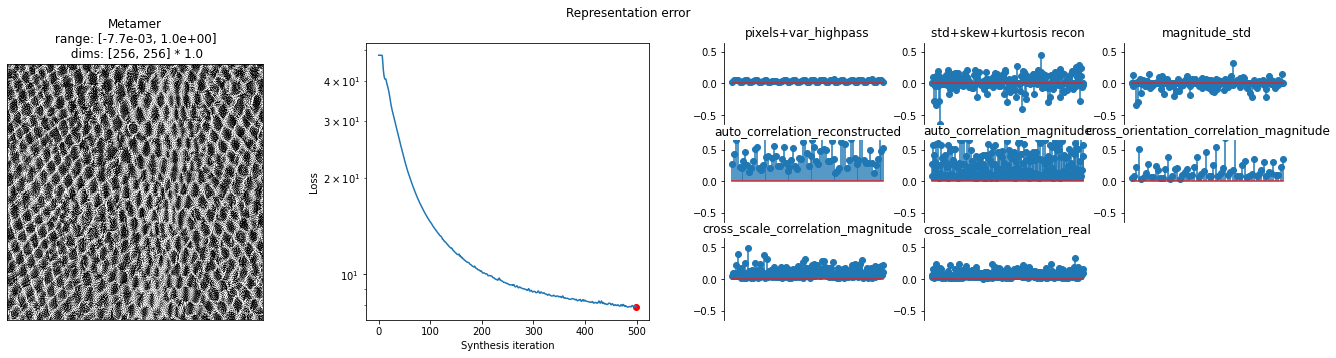

In [16]:
po.synth.metamer.plot_synthesis_status(met, width_ratios={'plot_representation_error': 2});

The leftmost image shows the resulting metamer, with the overall loss in the middle (we can see that we could keep going), and the representation loss on the right. This representation loss shows the error in each class of model statistics.

Just for fun, we can animate this plot (though currently, our ability to update the ylimits on the representation loss plots isn't working):

In [17]:
po.synth.metamer.animate(met, width_ratios={'plot_representation_error': 2})

/mnt/home/wbroderick/plenoptic/src/plenoptic/synthesize/metamer.py:1647: UserWarning: Looks like representation is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like representation is image-like, haven't fully thought out how"


Let's do this on a different image:

In [18]:
img = po.data.einstein().to(DEVICE)
met = po.synth.MetamerCTF(img, ps_mask, loss_function=po.tools.optim.l2_norm,)

/mnt/home/wbroderick/plenoptic/src/plenoptic/tools/validate.py:178: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(
/mnt/home/wbroderick/plenoptic/src/plenoptic/tools/validate.py:211: UserWarning: Validating whether model can work with coarse-to-fine synthesis -- this can take a while!
  warnings.warn("Validating whether model can work with coarse-to-fine synthesis -- this can take a while!")


In [19]:
met.synthesize(max_iter=500, store_progress=10, change_scale_criterion=None, ctf_iters_to_check=7)

100%|██████████| 500/500 [00:29<00:00, 16.75it/s, loss=2.8495e+00, learning_rate=0.01, gradient_norm=7.5833e-01, pixel_change_norm=1.5028e-01, current_scale=all, current_scale_loss=2.8495e+00]            


/mnt/home/wbroderick/plenoptic/src/plenoptic/tools/display.py:931: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


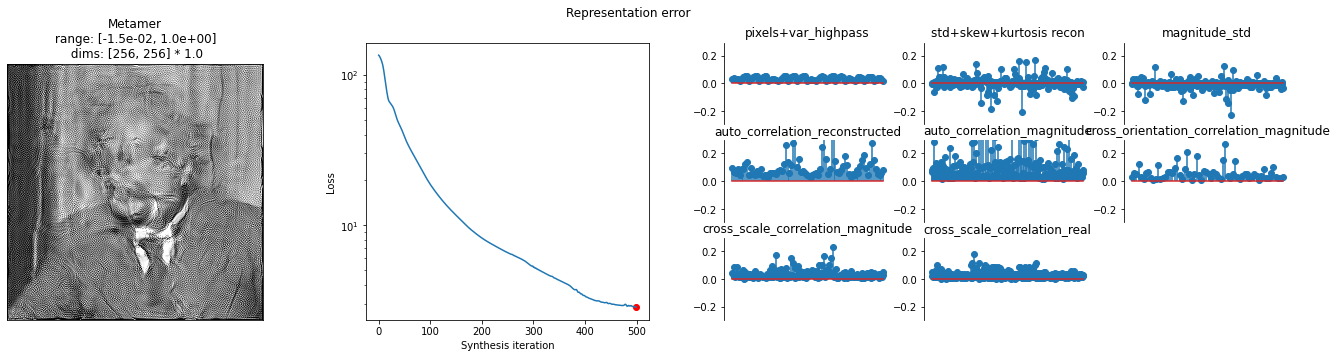

In [20]:
po.synth.metamer.plot_synthesis_status(met, width_ratios={'plot_representation_error': 2});

The code *should* work with any set of masks that the user provides, assuming the sum is roughly 1 for any of them. In particular, users may want to use the foveated pooling windows used in Freeman and Simoncelli, 2011, and other places. Those are not present in plenoptic, but a plenoptic-compatible implementation, also written by me, can be found [here](https://github.com/LabForComputationalVision/pooling-windows).

Question: that's currently not a package, and so cannot be installed, but I maintain it -- should I package it up? My hesitation is that it's much more research code than production code.

Regardless, if the user clones that github repo and then uses the following line to add it to their path and import it:

In [21]:
import sys
sys.path.append('../../pooling-windows/')
import pooling

We can then make use of them. There are two versions, either Freeman's original raised-cosine functional form or the smoother (but more memory intensive) Gaussian ones used in [Broderick et al., 2023](https://elifesciences.org/reviewed-preprints/90554). For the texture model, doesn't seem to matter which:

In [22]:
pw = pooling.PoolingWindows(.5, img.shape[-2:], max_eccentricity=5)
pooling_windows = [pw.ecc_windows[0], pw.angle_windows[0]]

/mnt/home/wbroderick/miniconda3/envs/plenoptic/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Note that these windows are specified in degrees of visual angle, and the width of the image in degrees is required. See the above papers for more details.

With these windows, we can see the importance of the rule that "all masks should sum to approximately 1". By visualizing the eccentricity windows, we can see that the most eccentric one goes off the image (this was necessary for the models in Broderick et al, 2024, but not for the texture one here):

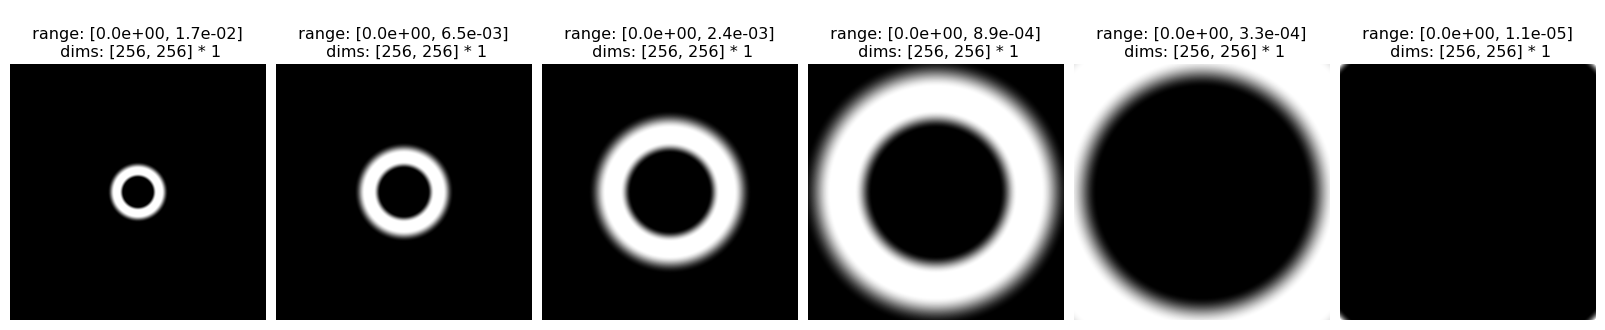

In [23]:
po.imshow(pooling_windows[0].unsqueeze(0));

Thus, when we take the sum, as we did above, we can see that the sum for these most eccentric windows decreases dramatically:

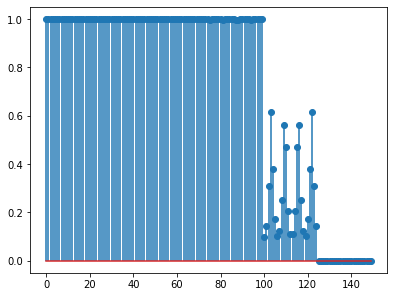

In [24]:
plt.stem(po.to_numpy(einops.einsum(*pooling_windows, 'm1 h w, m2 h w -> m1 m2').flatten()));

If we were to create a model using these windows, we can see that the kurtosis recon stats are much higher than the other ones, which will make optimization difficult:

(<Figure size 1080x360 with 8 Axes>,
 [<Axes: title={'center': 'pixels+var_highpass'}>,
  <Axes: title={'center': 'std+skew+kurtosis recon'}>,
  <Axes: title={'center': 'magnitude_std'}>,
  <Axes: title={'center': 'auto_correlation_reconstructed'}>,
  <Axes: title={'center': 'auto_correlation_magnitude'}>,
  <Axes: title={'center': 'cross_orientation_correlation_magnitude'}>,
  <Axes: title={'center': 'cross_scale_correlation_magnitude'}>,
  <Axes: title={'center': 'cross_scale_correlation_real'}>])

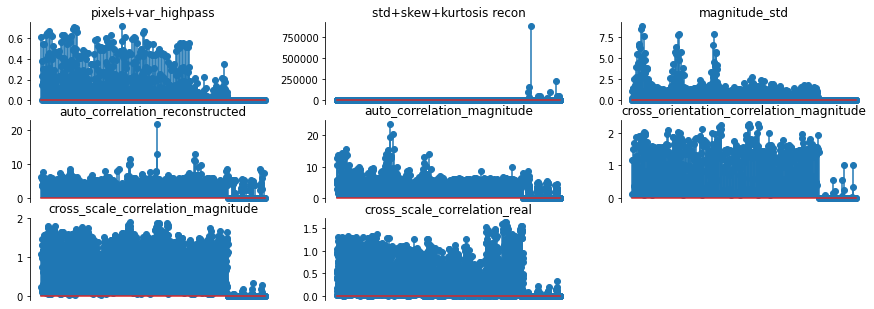

In [25]:
ps_mask = po.simul.PortillaSimoncelliMasked(img.shape[-2:], pooling_windows).to(DEVICE)
ps_mask.plot_representation(ps_mask(img))

We should thus ignore that final window:

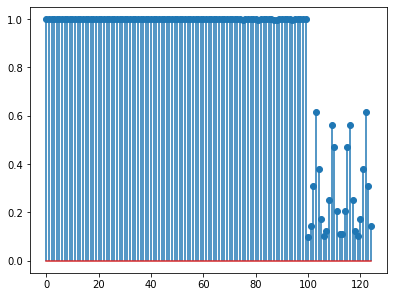

In [26]:
pooling_windows = [pw.ecc_windows[0][:-1], pw.angle_windows[0]]
plt.stem(po.to_numpy(einops.einsum(*pooling_windows, 'm1 h w, m2 h w -> m1 m2').flatten()));

When we do that, we can see that we still have some windows whose sum is below one, but they're still at least 0.1 and this seems to work fine.

In [27]:
ps_mask = po.simul.PortillaSimoncelliMasked(img.shape[-2:], pooling_windows).to(DEVICE)

In [28]:
met = po.synth.MetamerCTF(img, ps_mask, loss_function=po.tools.optim.l2_norm,)

In [29]:
met.synthesize(max_iter=500, store_progress=10, change_scale_criterion=None, ctf_iters_to_check=7)

100%|██████████| 500/500 [00:35<00:00, 13.90it/s, loss=2.4773e+01, learning_rate=0.01, gradient_norm=4.1683e+01, pixel_change_norm=2.2966e-01, current_scale=all, current_scale_loss=2.4773e+01]            


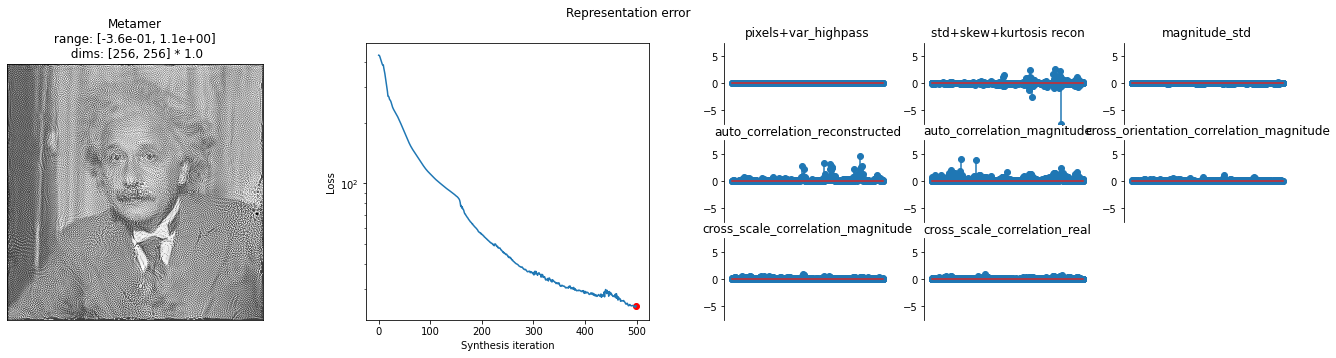

In [30]:
po.synth.metamer.plot_synthesis_status(met, width_ratios={'plot_representation_error': 2});

In [31]:
po.synth.metamer.animate(met, width_ratios={'plot_representation_error': 2})

/mnt/home/wbroderick/plenoptic/src/plenoptic/synthesize/metamer.py:1647: UserWarning: Looks like representation is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like representation is image-like, haven't fully thought out how"


Tada! `pw`, the `PoolingWindows` object we created, has some utilities for visualizing the windows:

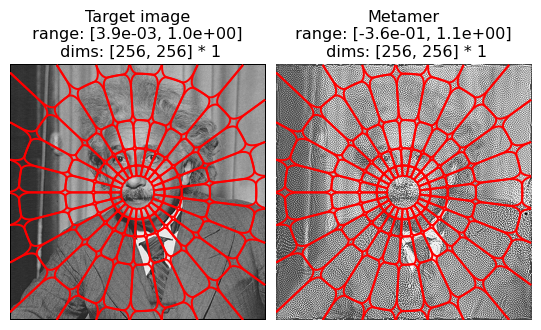

In [32]:
fig = po.imshow([img, met.metamer], title=['Target image', 'Metamer']);
for ax in fig.axes:
    pw.plot_windows(ax, subset=False)